# Praca domowa 2 Marcin Wilk#

In [35]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer

In [36]:
df=pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Wstęp do uczenia maszynowego\\Dane\\allegro-api-transactions.csv")

In [37]:
df.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      420020 non-null  int64  
 1   date                    420020 non-null  object 
 2   item_id                 420020 non-null  int64  
 3   categories              420020 non-null  object 
 4   pay_option_on_delivery  420020 non-null  int64  
 5   pay_option_transfer     420020 non-null  int64  
 6   seller                  420020 non-null  object 
 7   price                   420020 non-null  float64
 8   it_is_allegro_standard  420020 non-null  int64  
 9   it_quantity             420020 non-null  int64  
 10  it_is_brand_zone        420020 non-null  int64  
 11  it_seller_rating        420020 non-null  int64  
 12  it_location             420020 non-null  object 
 13  main_category           420020 non-null  object 
dtypes: float64(1), int64

## 1. Kodowanie zmiennych kategorycznych

In [39]:
import category_encoders as ce

### Target encoder

Jako że target encoding jest mocno zależny od rozkładu zmiennej target, sprawdźmy czy nasza zmienna **price** nie posiada jakiegoś "patologicznego" rozkładu.

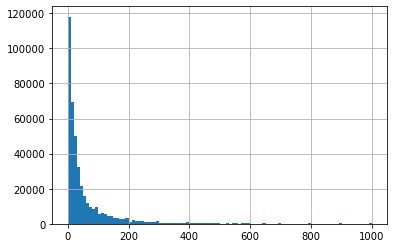

In [40]:
(df["price"])[df["price"]<1000].hist(bins=100)

Rozkład wydaje się być ciągły, przypomina wykładniczy.

In [41]:
df["it_location"].value_counts()

Warszawa                         23244
Kraków                           15135
Łódź                             10935
Poznań                           10610
Wrocław                           8646
                                 ...  
Okolice Dębicy                       1
WARSZAWA-RADOŚĆ UL.LEWKONII 5        1
Nowa Karczma                         1
Wielikowo                            1
NET-NET                              1
Name: it_location, Length: 10056, dtype: int64

Jak widzimy mamy bardzo wiele kategorii w naszej zmiennej **it_location**. One-hot encoding wyprodukowałby nam w tym przypadku ponad 10.000 nowych kolumn, co jest oczywiście bardzo niepożądane, więc tutaj przewagę ma target encoding. Spróbujemy zatem target encodingu przyjmując jako target zmienną price.

In [42]:
encoder = ce.TargetEncoder()
df["it_location_encoded"] = encoder.fit_transform(df["it_location"], df["price"])

In [43]:
df[["it_location","it_location_encoded"]]

,it_location,it_location_encoded
0,Warszawa,85.423398
1,Warszawa,85.423398
2,Leszno,61.990914
3,Wola Krzysztoporska,35.433365
4,BIAŁYSTOK,117.191956
...,...,...
420015,Kraśnik,24.306929
420016,Dzierżoniów,66.785334
420017,Supraśl,18.682800
420018,Poznań,106.203076


In [44]:
df["it_location_encoded"].value_counts()

85.423398     23244
77.043450     15135
58.929671     10935
106.203076    10610
89.829244      8646
              ...  
156.634649        2
132.506061        2
34.730631         2
217.312511        2
44.453710         2
Name: it_location_encoded, Length: 6283, dtype: int64

Porównując to z poprzednią tabelką value_counts można zauważyć, że znacznie zmiejszyła nam się liczba różnych wartości w porównaniu do stanu sprzed kodowania. Jest prawie 4000 różnych wartości mniej, co oznacza, że niektóre klasy zostały połączone i zakodowane jako jedna, co sprawia, że teraz osobne kategorie są z punktu widzenia algorytmu nierozróżnialne, w przeciwieństwie do one-hot encoding, gdzie zawsze nasze kodowanie będzie bijekcją. Stało się tak na przykład z wszystkimi klasami o liczności 1, co pokazuje, że lepiej sprawdziłby się chyba dla klas o większych licznościach, gdzie lepiej moglibyśmy estymować prawdopodobieństwa w grupach. Jednak target encoding wyprodukuje nam zawsze tylko jedną kolumnę, co sprawia, że nie przybywa nam danych w naszym zbiorze. 

### One-hot encoder


In [45]:
df["main_category"].value_counts()

Dom i Ogród                            91042
Odzież, Obuwie, Dodatki                54257
Motoryzacja                            45941
Dla Dzieci                             42107
Uroda                                  28096
Sport i Turystyka                      27532
RTV i AGD                              20341
Telefony i Akcesoria                   19805
Komputery                              14491
Zdrowie                                13166
Książki i Komiksy                      11572
Delikatesy                              8074
Gry                                     7150
Rękodzieło                              6574
Kolekcje                                6146
Przemysł                                5959
Biżuteria i Zegarki                     5808
Biuro i Reklama                         3194
Fotografia                              2381
Muzyka                                  1961
Antyki i Sztuka                         1214
Konsole i automaty                      1053
Filmy     

Widzimy, że tutaj liczba kategorii nie jest aż taka ogromna, stąd możemy zastosować one-hot encoding.

In [46]:
encoder = ce.OneHotEncoder()
encoder.fit_transform(X=df["main_category"])

,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,main_category_10,...,main_category_18,main_category_19,main_category_20,main_category_21,main_category_22,main_category_23,main_category_24,main_category_25,main_category_26,main_category_27
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420015,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420016,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
420017,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420018,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Kodowaie tylu kategorii nie trwało wcale tak długo, lecz możemy mieć i tak problemy przy przetwarzaniu tylu dodatkowych kolumn.

### Generalized Linear Mixed Model Encoder

Jest to encoder podobny do target encodera, gdyż również potrzebuje on dodatkowej zmiennej poza kodowaną na podstawie której bedzie mógł zakodować **main_category**. Jako target zastosujemy tutaj również zmienną **price**.

In [47]:
encoder = ce.GLMMEncoder()
df["main_category_GLMM"] = encoder.fit_transform(X=df["main_category"],y=df["price"])

In [48]:
df["main_category_GLMM"].value_counts()

-2.134077     91042
 1.285284     54257
 59.747451    45941
-3.357745     42107
-46.304636    28096
 20.548373    27532
 32.828761    20341
 6.764244     19805
 46.968712    14491
-31.661761    13166
-49.188465    11572
-54.748067     8074
-33.201435     7150
-66.407798     6574
-29.307974     6146
 4.239813      5959
-19.189969     5808
-40.007215     3194
 64.154684     2381
-36.117471     1961
 31.520961     1214
 67.815489     1053
-38.126565     1005
 59.993116      617
 48.589430      413
 7.018303       119
-1.721442         2
Name: main_category_GLMM, dtype: int64

Kodowanie zajęło chwilę dłużej niż one-hot, ale jak widzimy otrzymaliśmy tylko jedną nową kolumnę. Przeglądając powyższą tabelkę i porównując liczności zakodowanych kategorii widzimy, że jest to kodowanie bijekcyjne.

### Count Encoder

Jest to bardzo prosty sposób kodowania, polega na przypisaniu każdej klasie jej liczności w naszym zbiorze. Patrząc na value_counts zmiennej **main_category** widzimy, że kodowanie to zadziała bez żadnego problemu, wszystkie klasy mają różne liczności.

In [49]:
encoder = ce.CountEncoder()
df["main_category_count"] = encoder.fit_transform(X=df["main_category"])
df["main_category_count"]

0         14491
1         54257
2         91042
3         11572
4         54257
          ...  
420015    20341
420016    28096
420017    54257
420018    42107
420019    45941
Name: main_category_count, Length: 420020, dtype: int64

## Uzupełnianie braków

Ograniczę liczbe rekordów, gdyż w innym przypadku będzie się to następne 2 lata liczyć.

In [50]:
import random
ind = random.sample(range(420020),50000)

In [51]:
df=df.iloc[ind,:].reset_index(drop=True)

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
df[["it_seller_rating","price","it_quantity"]].describe()

,it_seller_rating,price,it_quantity
count,50000.000000,50000.000000,50000.000000
mean,20433.358980,76.888345,6765.393020
std,36540.731548,331.381811,23454.331866
min,0.000000,0.000000,0.000000
25%,1590.000000,9.000000,6.000000
50%,6799.000000,25.000000,95.000000
75%,21035.500000,68.992500,931.000000
max,292069.000000,46000.000000,99999.000000


### Usunięcie it_seller_rating

In [54]:
RMSE1 = [0] * 10
for i in range(10):
    nan_ind = random.sample(range(50000),5000)
    df1 = df[["it_seller_rating","price","it_quantity"]]
    df1.iloc[nan_ind,0]= float("NaN")
    imputer = KNNImputer(n_neighbors=5, weights= "distance")
    df2 = imputer.fit_transform(df1)
    RMSE1[i] = np.sqrt(np.mean((((df["it_seller_rating"])-pd.Series(df2[:,0]))[nan_ind])**2))

In [55]:
RMSE1

[39719.39867177484,
 39438.08589186221,
 40405.628263082705,
 39194.434880921915,
 38711.94661795152,
 40687.30031184313,
 39032.903923417405,
 37631.42651615311,
 38495.73923183847,
 39875.362657104626]

In [56]:
np.std(RMSE1)

867.6744769879454

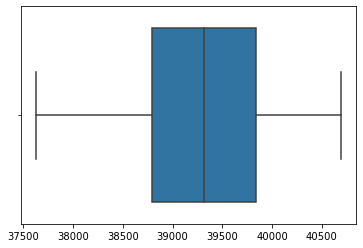

In [57]:
sns.boxplot(RMSE1)
plt.show()

Wnioski z analizy imputacji:
+ Wartości imputowane różnią się bardzo dużo od wartości oryginalnych, RMSE jest bardzo wysokie.
+ Odchylenie standardowe błędu RMSE jest całkiem duże, lecz w porównaniu do jego wartości oraz na przykład odchyleń zmiennych **it_seller_rating** oraz **it_quantity** jest ono całkiem znośne. Możemy zatem przypuszczać, że imputacja ta działa podobnie jakościowo dla każdego podzbioru danych.
+ Rozkład odchylenia RMSE jest podobny do rozkładu normalnego.
+ Duże wartości RMSE mogą jednak wynikać również z tego, że nasze wejściowe zmienne mają bardzo wysokie wartości, możliwe, że przydałaby się pewna standaryzacja/skalowanie przed imputacją.

### Usunięcie it_seller_rating oraz it_quantity

In [58]:
RMSE2 = [0] * 10
RMSE3 = [0] * 10
for i in range(10):
    nan_ind1 = random.sample(range(50000),5000)
    nan_ind2 = random.sample(range(50000),5000)
    df3 = df[["it_seller_rating","price","it_quantity"]]
    df3.iloc[nan_ind1,0]= float("NaN")
    df3.iloc[nan_ind2,2]= float("NaN")
    imputer = KNNImputer(n_neighbors=5, weights= "distance")
    df4 = imputer.fit_transform(df3)
    RMSE2[i] = np.sqrt(np.mean(((df["it_seller_rating"]-pd.Series(df4[:,0]))[nan_ind1])**2))
    RMSE3[i] = np.sqrt(np.mean(((df["it_quantity"]-pd.Series(df4[:,2]))[nan_ind2])**2))

In [59]:
RMSE2

[41890.26292629654,
 39313.64760864885,
 39441.76669414209,
 39798.56112947562,
 38992.18090797457,
 40896.762313237516,
 39096.342495188044,
 43893.479932401366,
 41197.8899351403,
 39480.23080804217]

In [60]:
np.std(RMSE2)

1493.1925796546088

In [61]:
RMSE3

[26258.112776096328,
 28270.158551267625,
 27717.285752073487,
 28950.65343374126,
 28226.43684915722,
 28091.05599501171,
 28244.979087284933,
 27079.861538262896,
 27155.1304031515,
 29034.37664133672]

In [62]:
np.std(RMSE3)

821.3605551053847

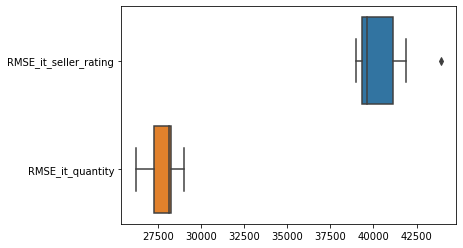

In [63]:
sns.boxplot(data=pd.DataFrame({"RMSE_it_seller_rating":RMSE2,"RMSE_it_quantity":RMSE3}),orient="h")
plt.show()

Wnioski z analizy imputacji:
+ Wartości imputowane kolejny raz różnią się bardzo dużo od wartości oryginalnych, RMSE jest bardzo wysokie dla obu zmiennych.
+ RMSE dla zmiennej **it_seller_rating** jest przeciętnie ciut większe niż w poprzednim przypadku, co jest całkiem zrozumiałe, gdyż tutaj mieliśmy braki również w innej kolumnie, co wpływa na działanie naszego algorytmu.
+ RMSE dla zmiennej **it_quantity** jest średnio prawie półtora raza mniejsze od RMSE **it_seller_rating**, jednak zmienna ta ma nominalnie większe wartości i odchylenie, stąd jej RMSE mogło wyjść sporo większe.
+ Odchylenia standardowe błędów RMSE są znowu całkiem spore, dla **it_seller_rating** jest wieksze niż w poprzednim przypadku. Dla **it_quantity** jest ono podobnego rzędu co w poprzednim przypadku. Można to wytłumaczyć tym, że przy większej ilości braków danych nasz algorytm imputuje wartości w sposób bardziej losowy, zależny od tego jakie dane akurat w danej iteracji usunęliśmy.
+ Rozkłady odchyleń obu RMSE są tym razem nieco skośne w stosunku do rozkładu normalnego.
+ Duże wartości RMSE mogą ponownie wynikać z tego, że nasze wejściowe zmienne mają bardzo wysokie wartości, możliwe, że przydałaby się pewna standaryzacja/skalowanie przed imputacją.